In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', cache=True)
mnist.target = mnist.target.astype(np.int8) 
sort_by_target(mnist) 

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

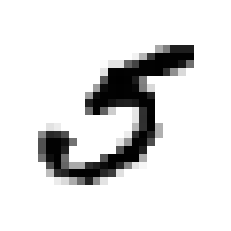

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
y[36000]

5

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [10]:
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
#Training a Binary Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96815
0.92615
0.96185


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9613, 0.9635, 0.9661])

In [15]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [17]:
#Confusion Matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54122,   457],
       [ 1725,  3696]])

In [19]:
#When it claims an image represents a 5, it is correct only 88.9% of the time. Moreover, it
#only detects 68% of the 5s
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8899590657356128

In [20]:
recall_score(y_train_5, y_train_pred)

0.6817930271167681

In [21]:
#The F 1 score is the harmonic mean of precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7720910800083559

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([5220.50278623])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

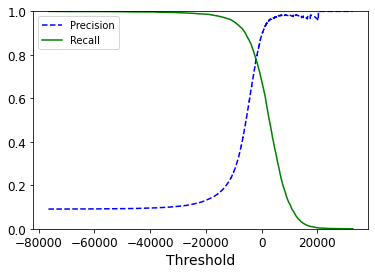

In [28]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [29]:
y_train_pred_90 = (y_scores > 0)

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.8899590657356128

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.6817930271167681

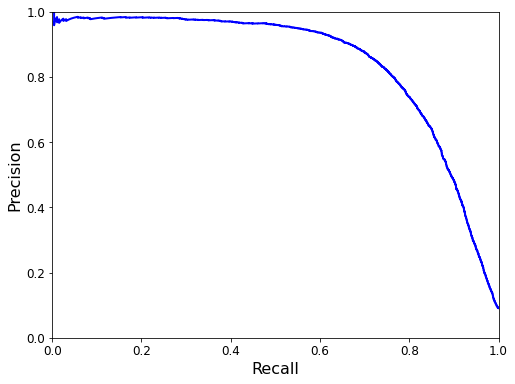

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [33]:
#The receiver operating characteristic (ROC) curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

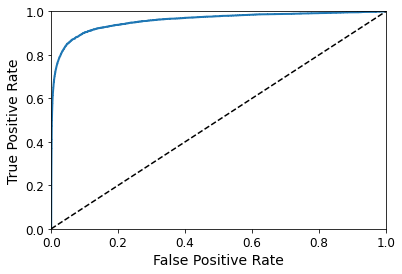

In [34]:
plot_roc_curve(fpr, tpr)
plt.show()

In [35]:
#AUC - area under curve
#you should prefer the PR curve whenever the positive class is rare or
#when you care more about the false positives than the false negatives, and the ROC curve otherwise
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9577210519742373

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

In [38]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

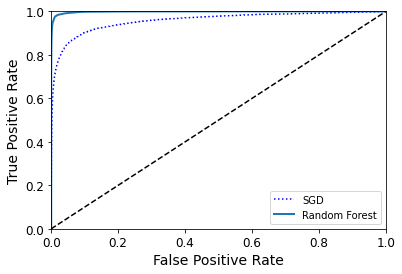

In [39]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983730844244434

In [41]:
#Multiclass Classification
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit]) 

array([5], dtype=int8)

In [46]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -8204.47519778, -19206.28224706,  -5702.10113982,
         -4666.3653033 , -15827.7809826 ,   1782.52380291,
        -39807.3747045 , -18945.8333413 , -14650.34384565,
        -16166.06981109]])

In [47]:
np.argmax(some_digit_scores)

5

In [48]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [49]:
sgd_clf.classes_[5]

5

In [50]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [51]:
len(ovo_clf.estimators_)

45

In [52]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [53]:
forest_clf.predict_proba([some_digit])

array([[0.06, 0.  , 0.01, 0.07, 0.  , 0.86, 0.  , 0.  , 0.  , 0.  ]])

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.88875, 0.8722 , 0.87905])

In [55]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9655, 0.9661, 0.9664])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/maksim/ml/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) 
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()